# PROJECT 2: BUSINESS PROCESS MINING (BPM)
* **COURSE:** CEI523 - ADVANCED TOPICS IN SOFTWARE ENGINEERING
* **STUDENTS:** Thomas Nikidiotis, Christos Christodoulou, Charalampos Charalampous
* **PROFESSOR:** DR. Andreas Andreou

### Αντικείμενο της παρούσας εργασίας είναι η Εξόρυξη Διαδικασιών (Process Mining). Η παρούσα εργασία εμπεριέχει 13 ερωτήματα τα οποία απαντώνται χρησιμοποιώντας την γλώσσα προγραμματισμού Python, την βιβλιοθήκη pm4py και τον επεξεργαστή κειμένου Jupyter notebook. Στην παρούσα αναφορά, θα απαντηθούν τα ερωτήματα της εργασίας παραθέτοντας τον κώδικα, τα διαγράμματα όπου υπάρχουν και screenshots από διαφορές διεργασίες.

In [1]:
# IMPORT LIBRARIES
import pm4py
import os
from tabulate import tabulate
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.conversion.wf_net import converter as wf_net_converter
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.objects.conversion.process_tree import converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

### Ερώτηση 1: Δίνεται το αρχείο ArtificialPatientTreatmentOriginal.xes. Να αναλύσετε τη δομή του και να περιγράψετε σύντομα τα βασικά της στοιχεία.

Στην παρούσα μελέτη έχουμε φορτώσει το αρχείο χρησιμοποιώντας την συνάρτηση xes_importer.apply('../data/ArtificialPatientTreatmentOriginal.xes'). Αξίζει να αναφερθεί ότι διαμέσου της βιβλιοθήκης pm4py υπάρχουν διάφοροι τρόποι φόρτωσης ενός αρχείου XES όπως φαίνεται στην πιο κάτω εικόνα:

In [2]:
# ΠΡΩΤΟΣ ΤΡΟΠΟΣ
# log = pm4py.read_xes('../data/ArtificialPatientTreatmentOriginal.xes')

# ΔΕΥΤΕΡΟΣ ΤΡΟΠΟΣ
log = xes_importer.apply('../data/ArtificialPatientTreatmentOriginal.xes')

Όσον αφορά τη δομή του αρχείου μπορούμε να την δούμε ευκολότερα αν μετατρέψουμε το πιο πάνω log σε πινακοποιημένη μορφή (DataFrame) όπως την εικόνα πιο κάτω:

In [3]:
df = pm4py.convert_to_dataframe(log)
print(len(log))
df.head()

101


,concept:name,org:resource,time:timestamp,case:concept:name
0,First consult,Dr. Anna,2017-01-02 11:40:11,patient 0
1,Blood test,Lab,2017-01-02 12:47:33,patient 0
2,Physical test,Nurse Jesse,2017-01-02 12:53:50,patient 0
3,Second consult,Dr. Anna,2017-01-02 16:21:06,patient 0
4,Surgery,Dr. Charlie,2017-01-05 13:23:09,patient 0


Το log μας φαίνεται ότι περιέχει στοιχεία και διαδικασίες που έλαβαν χώρα σε ένα ιατρείο ή σε ένα νοσοκομείο. Αυτό που μπορούμε να δούμε είναι ότι υπάρχουν 101 traces όταν τυπώνουμε το μήκος του log και μπορούμε να δούμε ότι υπάρχουν τέσσερις στήλες: `concept:name`, `org:resource`, `time:timestamp` και `case:concept:name`. Ένα XES αρχείο, έχει συγκεκριμένη σύνταξη (concrete syntax) και είναι βασισμένο στην σύνταξη XML. Όταν φορτώνουμε το XES αρχείο στην Python, τότε λέμε ότι φορτώνουμε ένα event log. 

To XES αρχείο που φορτώσαμε παρατηρούμε να υπάρχουν τρεις επεκτάσεις: `Concept (concept:)`, `Time(time:)` και `Organizational (org:)`. Για κάθε μια από αυτές τις επεκτάσεις υπάρχει επιπλέον ένα πρόθεμα (prefix) και στην περίπτωση μας βλέπουμε να είναι το name, to resource το timestamp και το `case:concept:name` το οποίο έχει δύο prefixes ένα μπροστά και ένα πίσω. Έχοντας τονίσει τα πιο πάνω, μπορούμε να δούμε ότι το log μας περιέχει τα εξής στοιχεία για κάθε ένα trace:

* concept:name: περιέχει στοιχεία για το όνομα του κάθε event όπως αυτό ορίζεται από το domain της κάθε επιχείρησης. Στην περίπτωση μας το όνομα αφορά το κάθε ένα event που έλαβε χώρα (π.χ. Εξέταση αίματος).
* org:resource: περιέχει στοιχεία για το ποιος ενεπλάκη στο κάθε event μέσα στο event log. Στην περίπτωση μας μπορεί να είναι π.χ. Ο Γιατρός που εξέτασε έναν ασθενή, ο εξεταστής, ο χημικός που ενήργησε στην ανάλυση αίματος και άλλοι δρώντες ενός νοσοκομείου.
* Time:timestamp: περιέχει στοιχεία για το ποτε ένα event αποθηκεύτηκε. Στην περίπτωση μας ίσως είναι ο χρόνος της κάθε μιας διαδικασίας που έλαβε χώρα στο κάθε trace.
* case:concept:name: περιέχει το μοναδικό χαρακτηριστικό ολόκληρου του trace. Το στοιχείο αυτό είναι το ίδιο για όλα τα events που γίνονται και εκτελούνται και αφορούν ένα συγκεκριμένο trace. Στο παράδειγμα μας αφορά το μονοπάτι που ακολούθησε ένας ασθενής σε ένα νοσοκομείο/ιατρείο.


### Ερώτηση 2: Χρησιμοποιώντας το αρχείο ArtificialPatientTreatmentOriginal.xes, να παράξετε το Petri net μοντέλο της διαδικασίας:

Χρησιμοποιώντας τον αλγόριθμο άλφα (alpha miner) μπορούμε διαμέσου της pm4py να παράξουμε το Petri Net μοντέλο όπως φαίνεται πιο κάτω:


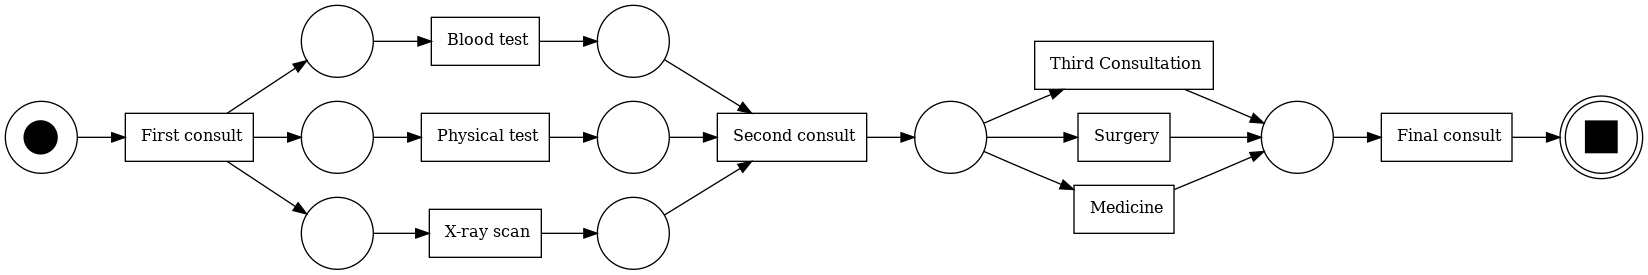

In [4]:
petri_net, initial_marking, final_marking = alpha_miner.apply(log)
graph = pn_visualizer.apply(petri_net, initial_marking, final_marking)
pn_visualizer.view(graph)

### Ερώτηση 3: Να παράξετε το Process Tree μοντέλο του σημείου (2) και μέσω αυτού να δημιουργήσετε το ΒΜΡΝ μοντέλο. Να σχολιάσετε (περιγράψετε) το BPMN μοντέλο που παράχθηκε.

Για την παραγωγή του Process Tree και του BPMN χρησιμοποιήθηκε ο πιο κάτω κώδικας και πιο κάτω μπορούμε να δούμε το Process Tree και στη συνέχεια το μοντέλο BPMN.

To BPMN μοντέλο που παράχθηκε είναι πιο απλοϊκό από το Petri net και βλέπουμε ότι έχει ως αρχή και ως τέλος το final consult. Στην αρχή, ύστερα από το First Consult έχει ένα AND gateway το οποίο αναπαρίσταται με το πρόσημο “+”. Το AND αυτό προδιαθέτει ότι πρέπει να συμβούν και τα τρία activities ταυτόχρονα. Στη συνέχεια υπάρχη άλλο ένα AND gateway που προδιαθέτει ότι πάντα ύστερα από τα προαναφερθέντα activities. Στη συνέχεια βλέπουμε να ακολουθεί ένα Exclusive gateway (XOR) στο οποίο ακολουθείτε ένα από τα επόμενα τρία είτε το third consultation είτε το surgery είτε το Medicine. Επιπλέον στη συνέχεια ύστερα από ένα από αυτά τα ακολουθείτε το Final consult και η διαδικασία που αναπαριστά το BPMN μοντέλο τελειώνει εκεί.

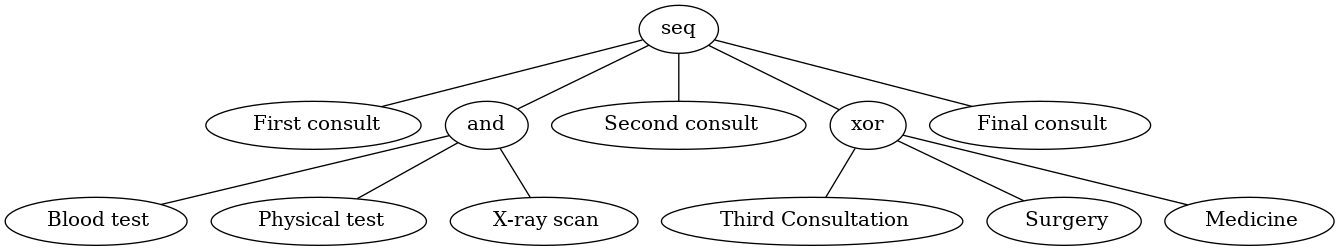

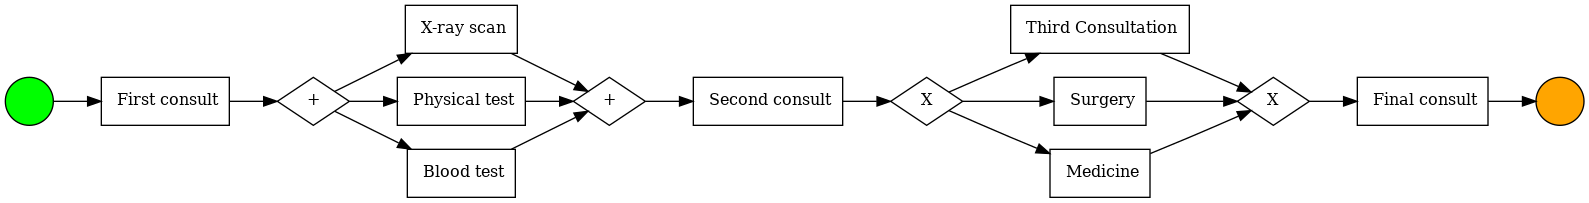

In [5]:
tree = wf_net_converter.apply(petri_net, initial_marking, final_marking)
gviz = pt_visualizer.apply(tree) #={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)
bpmn_graph = converter.apply(tree, variant=converter.Variants.TO_BPMN)
pm4py.view_bpmn(bpmn_graph)

### Ερώτηση 4: Να χρησιμοποιήσετε κατάλληλες εντολές και συναρτήσεις της Python ώστε να παράξετε απευθείας το ΒΡΜΝ μοντέλο του σημείου (2) χωρίς τη χρήση Process Tree.

Για να παράξουμε το BPMN χωρίς την προϋπόθεση να δημιουργηθεί το Process Tree χρισιμοποιήσαμε τις πιο κάτω εντολές της Python:


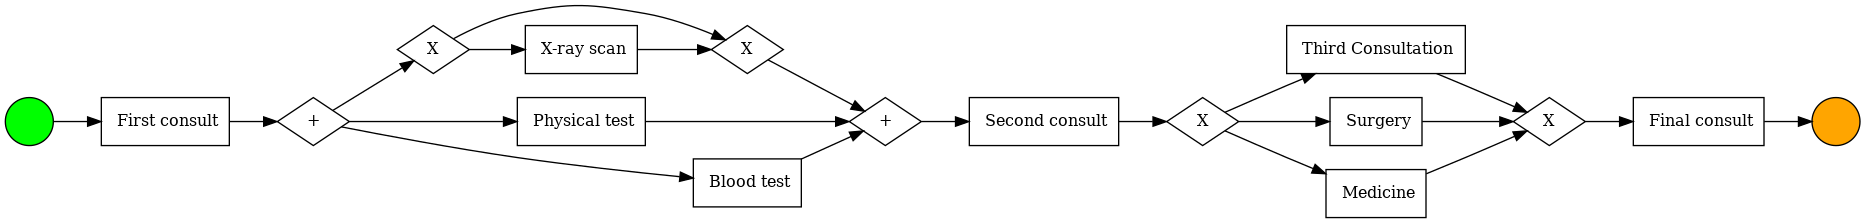

In [6]:
process_model = pm4py.discover_bpmn_inductive(log)
pm4py.view_bpmn(process_model)

### Ερώτηση 5: Να συγκρίνετε τη δομή των δύο μοντέλων στα σημεία (3) και (4). Τι παρατηρείτε;
Το BPMN του ερωτήματος 3 βλέπουμε ότι χρειάζονται να γίνουν 3 activities παραλληλα για να φτάσουμε στο Second Consultation activity. Στο δεύτερο BPMN του ερωτήματος 4 παρατηρούμε ότι το activity X-ray Scan μπορεί να προσπελαστεί και να μην εκτελεστεί ενώ το Physical Test και το Blood test συμβαίνουν πάντα. Αυτό αναδικνύει μια κρυφή πτυχή στα event logs όπου ίσως να μην υπάρχει σε όλα τα traces το X-ray scan και αυτό να μπορεί να προσπεραστεί. Επομένως στο log μας ίσως να μην υπάρχει σε όλα τα traces το event X-ray Scan.


### Ερώτηση 6: Να αιτιολογήσετε ποιο μοντέλο θα προτιμούσατε να χρησιμοποιήσετε ως βάση για την ανάλυση της διαδικασίας της εταιρείας, το Petri Net του σημείου (2) ή το ΒΡΜΝ του σημείου (3);
Το μοντέλο που θα προτιμούσαμε είναι το BPMN του ερωτήματος 4 διότι μπορεί να εξηγήσει καλύτερα την διαδικασία εξέτασης ενός ασθενή και μπορεί να αναδείξει περισσότερες πτυχές της διαδικασίας. Συγκεκριμένα, βλέπουμε ότι στο log παραλείπεται σε 10 traces το X-ray Scan και γι αυτό θεωρούμε ότι αναπαρίσταται καλύτερα η διαδικασία μέσω του BPMN του ερωτήματος 4. Ο λόγος έγκειται στο γεγονός ότι πρέπει να αποτυπώσουμε διαμέσου του μοντέλου όσο καλύτερα γίνεται την πραγματική διαδικασία. Η πραγματική διαδικασία φαίνεται να αναπαρίσταται καλύτερα και να αντιπροσωπεύει την πραγματικότητα από το BPMN του ερωτήματος 4.


### Ερώτηση 7: Να τροποποιήσετε κατάλληλα το αρχείο ArtificialPatientTreatmentOriginal.xes ώστε να δημιουργηθούν εμβόλιμα οι νέες καταστάσεις (transitions) και θέσεις (places) στο Petri net του σημείου (2) αμέσως πριν την τελική μετάβαση, που να το επεκτείνουν όπως φαίνεται στο πιο κάτω σχήμα:

Το νέο αρχείο ονομάζεται ArtificialPatientTreatmentOriginal_new.xes και μέσω του alpha miner παράγεται το πιο κάτω Petri Net.

Για να πετύχουμε το πιο κάτω αποτέλεσμα τροποποιήσαμε το XES αρχείο ως εξής:
Προσθέσαμε ύστερα από κάθε final consult στα μισά traces Blood Sugar Test και Decision for Heart Surgery και στα άλλα μισά traces ECG και Decision for Heart Surgery έτσι ώστε να δημιουργηθεί μια XOR διαδικασία. Το αποτέλεσμα μπορείτε να το δείτε στο αρχείο `../data/ArtificialPatientTreatmentOriginal_new.xes`


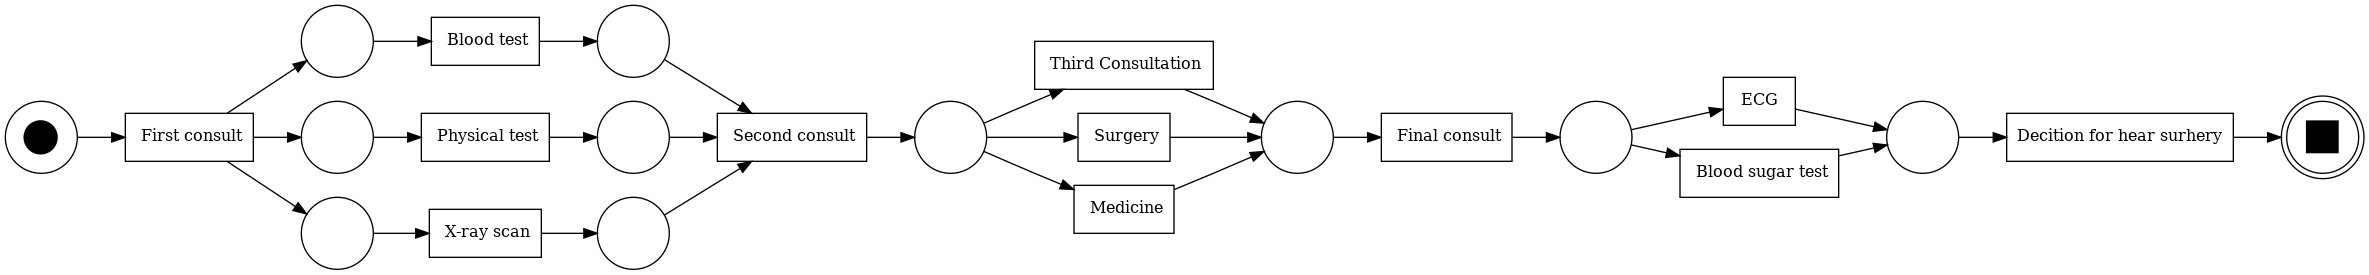

In [7]:
traces2 = pm4py.read_xes('../data/ArtificialPatientTreatmentOriginal_new.xes')
petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(traces2)
graph2 = pn_visualizer.apply(petri_net, initial_marking, final_marking)
pn_visualizer.view(graph2)

### Ερώτηση 8: Χρησιμοποιήστε το αρχείο new.xes και να παράξετε ξανά το μοντέλο διαδικασιών Petri net και το ΒΡΜΝ μοντέλο όπως στα σημεία (2) και (3) αντίστοιχα.

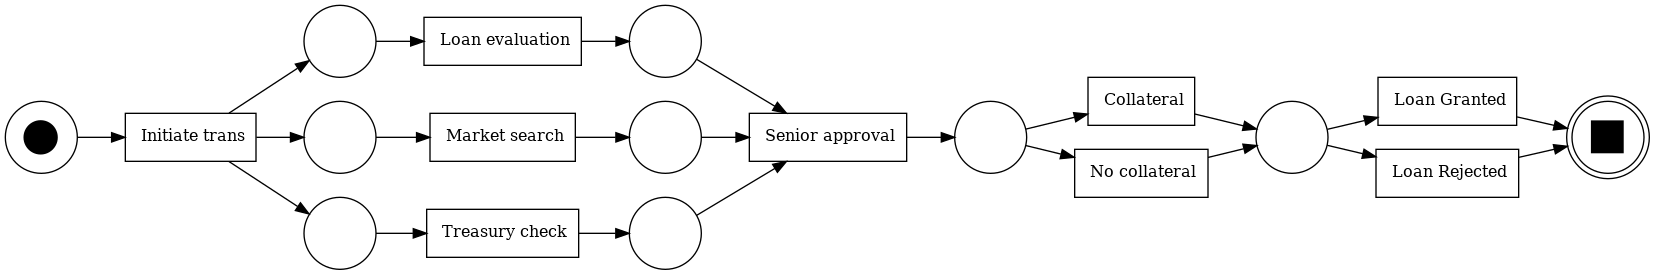

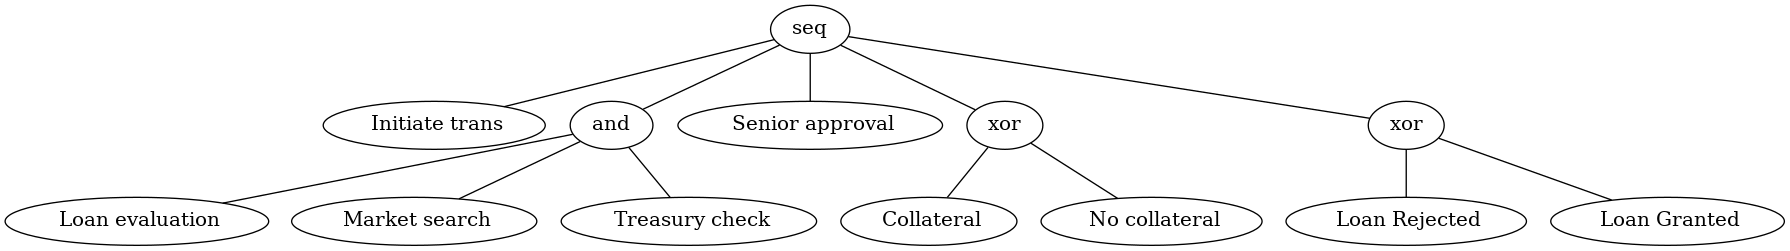

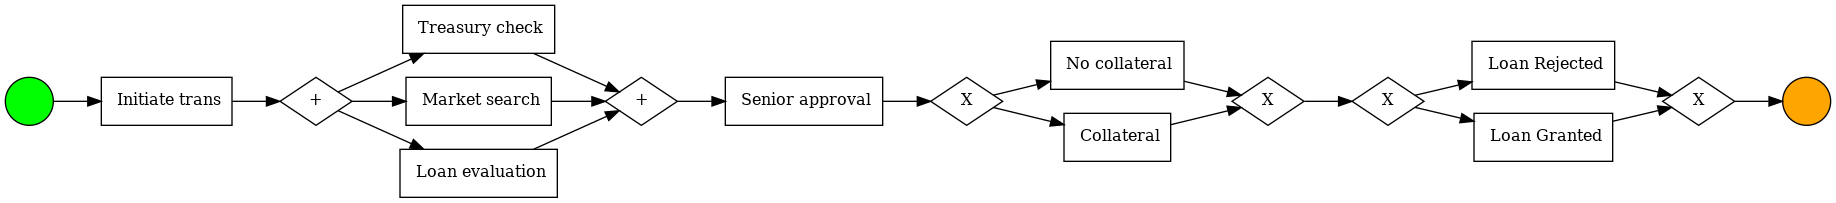

In [8]:
traces3 = pm4py.read_xes('../data/new.xes')
petri_8, initial_8, final_8 = pm4py.discover_petri_net_alpha(traces3)
graph2 = pn_visualizer.apply(petri_8, initial_8, final_8)
pn_visualizer.view(graph2)
tree2 = wf_net_converter.apply(petri_8, initial_8, final_8)
gviz2 = pt_visualizer.apply(tree2) #={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz2)
bpmn_graph2 = converter.apply(tree2, variant=converter.Variants.TO_BPMN)
pm4py.view_bpmn(bpmn_graph2)

### Ερώτηση 9: Να χρησιμοποιήσετε κατάλληλες συναρτήσεις της Python ώστε να απεικονίσετε τη συχνότητα εμφάνισης των καταστάσεων στο Petri net του σημείου (8).

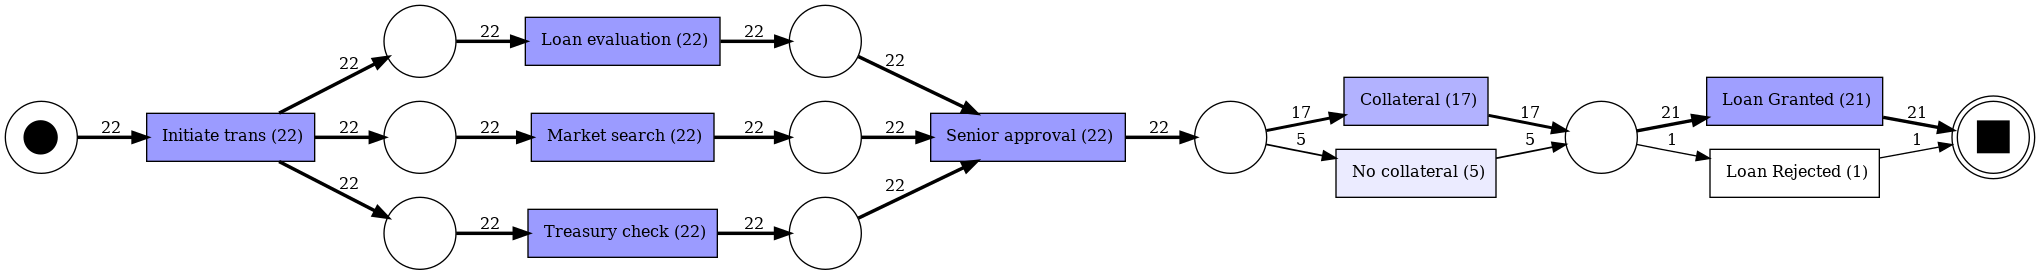

In [9]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(petri_8, initial_8, final_8, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=traces3)
pn_visualizer.save(gviz, "inductive_frequency.png")
from IPython.display import display, Image
display(Image(filename='inductive_frequency.png'))

### Ερώτηση 10: Να χρησιμοποιήσετε κατάλληλες συναρτήσεις της Python ώστε να απεικονίσετε το heuristic net του αρχείου new.xes, που είναι μια άλλη μορφή transition system, και να το εξηγήσετε.

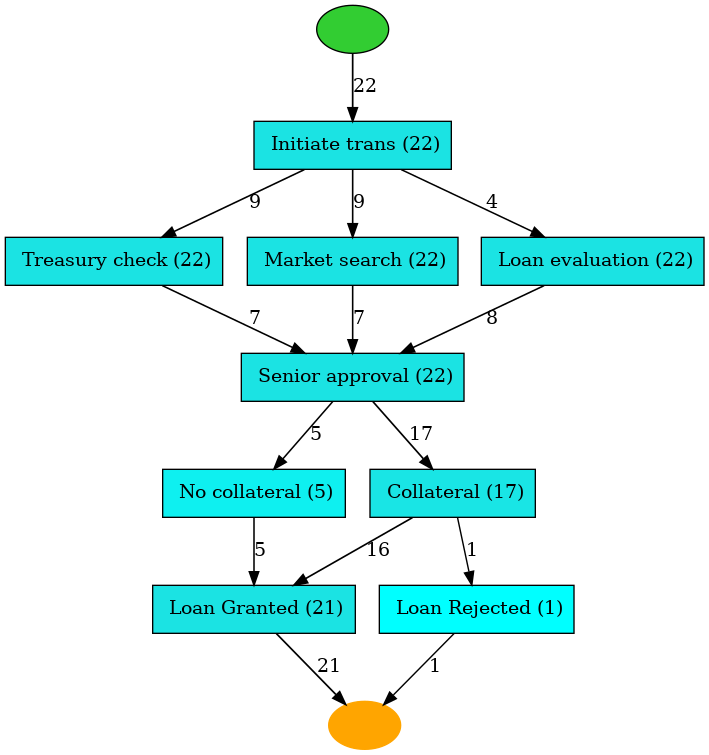

In [10]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
traces4 = pm4py.read_xes('../data/new.xes')
heu_net = heuristics_miner.apply_heu(traces4)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

##### Εξήγηση Heuristic Net: 
Όπως βλέπουμε στις παρενθέσεις κάθε κατάσταση του Heuristic Net περιέχει πόσες φορές αυτή η κατάσταση εμφανίζεται στο log. Δηλαδή, πόσες φορές ένα event εμφανίζεται στα traces μας. 
Επιπλέον παρατηρούμε ότι σε κάποιες περιπτώσεις δεν έχουμε 22 αλλά έχουμε λιγότερα και αυτό συμβάινει διότι έχουμε XOR (είτε μια κατάσταση είτε μια άλλη). Έτσι παρατηρούμε ότι σε τέτοιες περιπτώσεις όπως η προαναφερθήσα έχουμε πάλι 22 φορές αλλά αρθροιστικά προσθέτωντας τις καταστάσεις που εμπλέκονται στο XOR.
 


### Ερώτηση 11: Με βάση το μοντέλο Petri Net του σημείου (8) να παραθέσετε όλα τα επιτρεπτά μονοπάτια εκτέλεσης και να τα μετατρέψετε σε πινακοποιημένη μορφή.

Ολα τα επιτρεπτά μονοπάτια με βάση το Petri Net του σημείου (8):
Initiate State, Loan Evaluation, Market Search, Treasure Check, Senior Approval, No collateral, Loan Rejected
Initiate State, Loan Evaluation, Market Search, Treasure Check, Senior Approval, No collateral, Loan Granted
Initiate State, Loan Evaluation, Market Search, Treasure Check, Senior Approval, Collateral, Loan Rejected
Initiate State, Loan Evaluation, Market Search, Treasure Check, Senior Approval, Collateral, Loan Granted

Με βάση τα πιο πάνω μοναδικά μονοπάτια που είναι δυνατόν να συμβούν με βάση το μοντέλο Petri Net του σημείου (8) δημιουργήσαμε την πινακοποιημένη μορφή για κάθε ένα από αυτά χρησιμοποιώντας τον πιο κάτω κώδικα: 



In [11]:
import pandas as pd
new_df = pd.DataFrame(columns=['Initiate State', 
                               'Loan Evaluation', 
                               'Market Search', 
                               'Treasure Check', 
                               'Senior Approval', 
                               'No collateral', 
                               'Collateral', 
                               'Loan Rejected', 
                               'Loan Granted'])
new_df.loc[len(new_df)] = [1,1,1,1,1,1,0,1,0]
new_df.loc[len(new_df)] = [1,1,1,1,1,1,0,0,1]
new_df.loc[len(new_df)] = [1,1,1,1,1,0,1,1,0]
new_df.loc[len(new_df)] = [1,1,1,1,1,0,1,0,1]

In [ ]:
new_df

### Ερώτηση 12: Να χρησιμοποιήσετε τα αρχεία new_replay1.xes και new_replay2.xes και το μοντέλο Petri Net του σημείου (8) για να κάνετε replay. Να περιγράψετε σύντομα τι παρατηρείτε σε κάθε περίπτωση και να αιτιολογήσετε το αποτέλεσμα.

Για να κάνουμε replay χρησιμοποιήσαμε την συνάρτηση token_replay της βιβλιοθήκης pm4py. Αυτό που παρατηρούμε είναι ότι στο πρώτο log (new_replay1.xes) όλα τα traces κάνουν fit στο μοντέλο, ενώ στο δεύτερο log (new_replay2.xes) φαίνεται ότι δύο από αυτά δεν κάνουν fit. Το αποτέλεσμα δηλαδή, οφείλεται στο γεγονός ότι στο new_replay2.xes δυο από αυτά δεν κάνουν fit στο μοντέλο που δημιουργήθηκε στο σημείο (8).

##### With new_replay1.xes

In [41]:
log1 = pm4py.read_xes('../data/new_replay1.xes')
replay1 = token_replay.apply(log1, petri_8, initial_8, final_8)
replay1

[{'trace_is_fit': True,
  'trace_fitness': 1.0,
  'activated_transitions': [ Initiate trans,
    Market search,
    Loan evaluation,
    Treasury check,
    Senior approval,
    Collateral,
    Loan Granted],
  'reached_marking': ['end:1'],
  'enabled_transitions_in_marking': set(),
  'transitions_with_problems': [],
  'missing_tokens': 0,
  'consumed_tokens': 10,
  'remaining_tokens': 0,
  'produced_tokens': 10},
 {'trace_is_fit': True,
  'trace_fitness': 1.0,
  'activated_transitions': [ Initiate trans,
    Treasury check,
    Loan evaluation,
    Market search,
    Senior approval,
    Collateral,
    Loan Granted],
  'reached_marking': ['end:1'],
  'enabled_transitions_in_marking': set(),
  'transitions_with_problems': [],
  'missing_tokens': 0,
  'consumed_tokens': 10,
  'remaining_tokens': 0,
  'produced_tokens': 10},
 {'trace_is_fit': True,
  'trace_fitness': 1.0,
  'activated_transitions': [ Initiate trans,
    Treasury check,
    Market search,
    Loan evaluation,
    Senior 

In [36]:
for i in replay1:
    print(i['trace_is_fit'])

True
True
True
True
True


##### Evaluate the model

In [17]:
fitness1 = replay_fitness_evaluator.apply(log1, petri_8, initial_8, final_8, 
                                          variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print('Fitness for log1: ',fitness1)
prec1 = precision_evaluator.apply(log1, petri_8, initial_8, final_8, 
                                   variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Precision for log1: ',prec1)
gen1 = generalization_evaluator.apply(log1, petri_8, initial_8, final_8)
print('Generalization for log1: ',gen1)
simp1 = simplicity_evaluator.apply(petri_8)
print('Simplicity for log1: ',simp1)


Fitness for log1:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



Precision for log1:  0.75



Generalization for log1:  0.44802904184712
Simplicity for log1:  0.7599999999999999


##### With new_replay2.xes

In [38]:
log2 = pm4py.read_xes('../data/new_replay2.xes')
replay2 = token_replay.apply(log2, petri_8, initial_8, final_8)
replay2

[{'trace_is_fit': True,
  'trace_fitness': 1.0,
  'activated_transitions': [ Initiate trans,
    Market search,
    Loan evaluation,
    Treasury check,
    Senior approval,
    Collateral,
    Loan Granted],
  'reached_marking': ['end:1'],
  'enabled_transitions_in_marking': set(),
  'transitions_with_problems': [],
  'missing_tokens': 0,
  'consumed_tokens': 10,
  'remaining_tokens': 0,
  'produced_tokens': 10},
 {'trace_is_fit': False,
  'trace_fitness': 0.8888888888888888,
  'activated_transitions': [ Initiate trans,
    Loan evaluation,
    Market search,
    Senior approval,
    Collateral,
    Loan Granted],
  'reached_marking': ["({' Initiate trans'}, {' Treasury check'}):1", 'end:1'],
  'enabled_transitions_in_marking': { Treasury check},
  'transitions_with_problems': [ Senior approval],
  'missing_tokens': 1,
  'consumed_tokens': 9,
  'remaining_tokens': 1,
  'produced_tokens': 9},
 {'trace_is_fit': True,
  'trace_fitness': 1.0,
  'activated_transitions': [ Initiate trans,
 

In [39]:
for i in replay2:
    print(i['trace_is_fit'])

True
False
True
False
True


##### Evaluate the model

In [ ]:
fitness2 = replay_fitness_evaluator.apply(log2, petri_8, initial_8, final_8, 
                                          variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print('Fitness for log2: ',fitness2)
prec2 = precision_evaluator.apply(log2, petri_8, initial_8, final_8, 
                                  variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Precision for log2: ',prec2)
gen2 = generalization_evaluator.apply(log2, petri_8, initial_8, final_8)
print('Generalization for log2: ',gen2)
simp2 = simplicity_evaluator.apply(petri_8)
print('Simplicity for log2: ',simp2)

### Comparisson of the two XES files through the model
Επομένως στη συνέχεια προχωρήσαμε σε μια μικρή αξιολόγηση του token_replay όπως αυτή ορίζεται από το documentation της pm4py χρησιμοποιώντας τέσσερις μετρικές: Fitness, Precision, Generalization και Simplicity

Μέσα από τις τρεις μετρικές: Fitness, Generalization, και Precision. 

* **Fitness**: Ο υπολογισμός της replay_fitness έχει στόχο να υπολογίσει πόσο από τη συμπεριφορά στο αρχείο καταγραφής γίνεται αποδεκτή από το μοντέλο διαδικασίας. Δηλαδή, ο σκοπός του replay fitness είναι να αναδείξει κατα πόσο ένα log είναι αποδεκτό από το μοντέλο. Όπως παρατηρείται το πρώτο log (new_replay1.xes) είναι αποδεκτό σε μεγαλύτερο ποσοστό από το δεύτερο log. Το πρώτο log φαίνεται να είναι ομοιο 100% με το μοντέλο που παράχθηκε στο σημείο (8). Το δεύτερο log φαίνεται να μην είναι 100% όμοιο αλλά 60% επομένως φαίνεται να υπάρχουν traces στο log που δεν αποτυπώνουν το μοντέλο 100%.

* **Generalization**: O σκοπός της μετρικής generalization είναι να αναδείξει κατα πόσο δύο logs είναι όμοια. To πρώτο log φαίνεται να είναι όμοιοτερο με το μοντέλο του σημείου (8) παρά με το δεύτερο log.

* **Precision**: Σκοπός της μετρικής Precision είναι να αναδείξει ποσο διαφορετικά είναι δύο logs με βάση ένα μοντέλο Petri Net. Όπως φαίνεται το δεύτερο log έχει ελάχιστα μεγαλύτερο Precision από το πρώτο log. 

Συμπερασματικά φάινεται το πρώτο log (new_replay1.xes) να μπορεί να κάνει fit καλύτερα στο μοντέλο και να είναι ομοιότερο από το δεύτερο log (new_replay2.xes). 



### Ερώτηση 13: Χρησιμοποιήστε το αρχείο new1.xes για να παράξετε ξανά το μοντέλο διαδικασιών Petri net όπως στο σημείο (2). Το αρχείο θα πρέπει να υλοποιεί την εξής συμπεριφορά: Η κατάσταση “Market search” πρέπει στη συνέχεια να ακολουθείται είτε από την κατάσταση “Market Evaluation” είτε από την “Market Analysis” και το αποτέλεσμα αυτών των δύο να ακολουθείται από την Senior Approval. Υλοποιείται πράγματι η συμπεριφορά αυτή με βάση το new1.xes; Πού οφείλεται το πρόβλημα; Να διορθώσετε το αρχείο αιτιολογώντας τις αλλαγές σας και να το αποθηκεύσετε με το όνομα new_final.xes.

Η συμπεριφορά δεν υλοποιείται εφόσον κάθε φορά που τρέχουμε τον αλγόριθμο άλφα για την παραγωγή του Petri Net αλλάζει η δομή του. Αυτό μας οδηγεί στο συμπέρασμα ότι τα event στα traces είναι ανακατεμένα και δεν έχουν ορθή σειρά όπως φαίνεται στην πιο κάτω εικόνα:


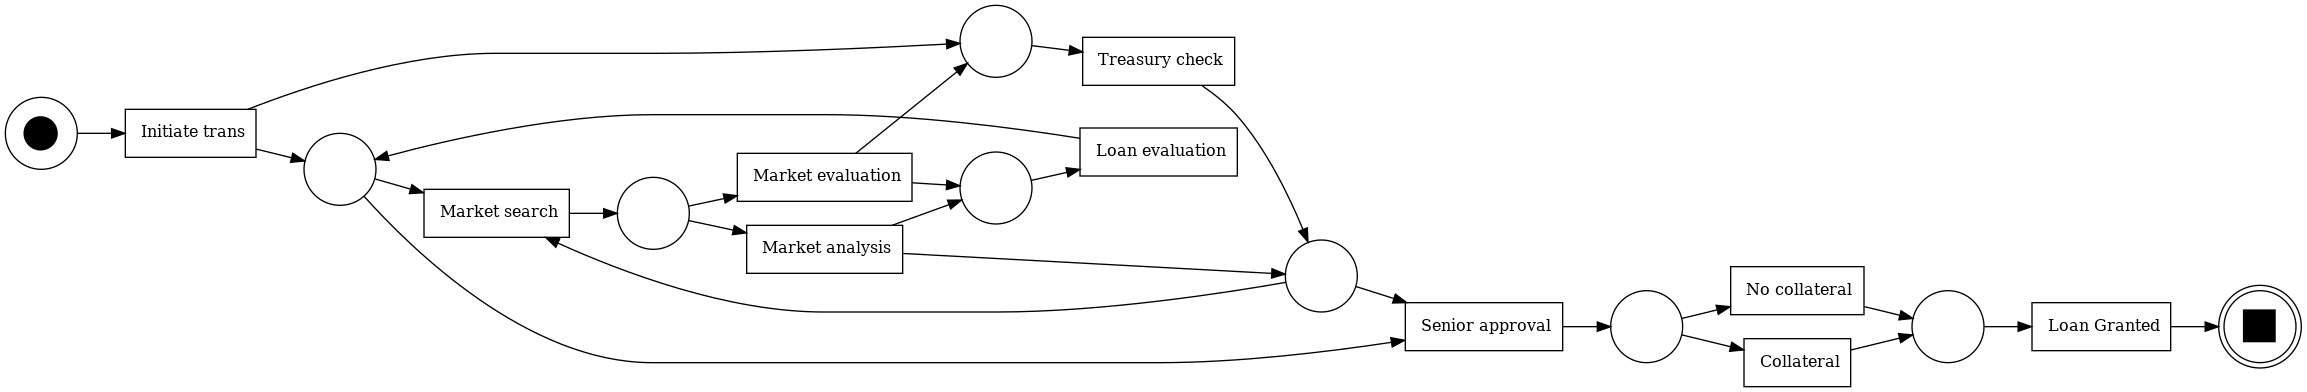

In [47]:
log = pm4py.read_xes('../data/new1.xes')
petriNet, initialMarking, finalMarking = pm4py.discover_petri_net_alpha(log)
graph = pn_visualizer.apply(petriNet, initialMarking, finalMarking)
pn_visualizer.view(graph)

Για να ολοκληρώσουμε το ερώτημα τροποποιήσαμε το αρχείο έτσι ώστε να υλοποιεί την συγκεκριμένη συμπεριφορά της εκφώνησης. Για την τροποποίηση / αναδιοργάνωση του αρχείου XES ακολουθήσαμε τα εξείς βήματα:
* Βάλαμε σε όλα τα traces το ‘treasury check’ δεύτερο
* Ακολούθως αμέσως επόμενο βάλαμε το Market Search 
* Στη συνέχεια προσθέσαμε εναλλάξ στα traces τα events ‘Market Evaluation’ και ‘Market Analysis’ ούτως ώστε να δημιουργήσουμε ένα XOR transition
* Τέλος, ύστερα από το Market Evaluation ή το Market Analysis προσθέσαμε να ακολουθεί πάντα το Senior Approval όπως ακριβώς ζητά η εκφώνηση

Τέλος, με την αναδιοργάνωση του αρχείου προκύπτει το πιο κάτω Petri Net:


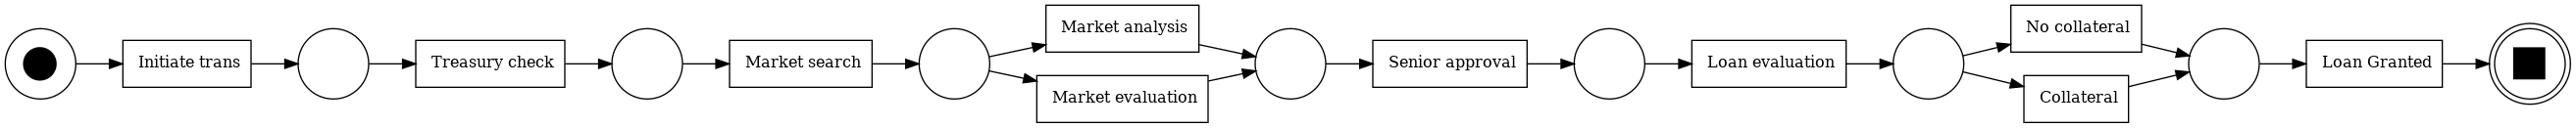

In [39]:
log = pm4py.read_xes('../data/new_final.xes')
petriNet, initialMarking, finalMarking = pm4py.discover_petri_net_alpha(log)
graph = pn_visualizer.apply(petriNet, initialMarking, finalMarking)
pn_visualizer.view(graph)